Nhóm Sinh Viên Báo Cáo
Họ tên: Phan Văn Tình

MSSV: 21424057

In [ ]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
from PIL import Image

In [ ]:
from numba import cuda
major, minor = cuda.get_current_device().compute_capability
print(f'GPU compute capability: {major}.{minor}')

GPU compute capability: 7.5


In [ ]:
def edge_detection(image_path, blur_ksize=7, sobel_ksize=1, skipping_threshold=30):
    """
    image_path: link to image
    blur_ksize: kernel size parameter for Gaussian Blurry
    sobel_ksize: size of the extended Sobel kernel; it must be 1, 3, 5, or 7.
    skipping_threshold: ignore weakly edge
    """
    # read image
    img = cv2.imread(image_path)
    
    # convert BGR to gray
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img_gaussian = cv2.GaussianBlur(gray, (blur_ksize, blur_ksize), 0)
    
    # sobel algorthm use cv2.CV_64F
    sobelx64f = cv2.Sobel(img_gaussian, cv2.CV_64F, 1, 0, ksize=sobel_ksize)
    abs_sobel64f = np.absolute(sobelx64f)
    img_sobelx = np.uint8(abs_sobel64f)

    sobely64f = cv2.Sobel(img_gaussian, cv2.CV_64F, 1, 0, ksize=sobel_ksize)
    abs_sobel64f = np.absolute(sobely64f)
    img_sobely = np.uint8(abs_sobel64f)
    
    # calculate magnitude
    img_sobel = (img_sobelx + img_sobely)/2
    
    # ignore weakly pixel
    for i in range(img_sobel.shape[0]):
        for j in range(img_sobel.shape[1]):
            if img_sobel[i][j] < skipping_threshold:
                img_sobel[i][j] = 0
            else:
                img_sobel[i][j] = 255
    return img_sobel

In [ ]:
#Hiển thị hình ảnh pnm
def show_pnm(file_name):
  with open(file_name, 'r') as f:
    vals = f.read().split()
  w = int(vals[1])
  h = int(vals[2])
  if vals[0] == 'P2': # Grayscale
    pixels = np.array(vals[4:], dtype=np.uint8).reshape((h, w))
  elif vals[0] == 'P3': # RGB
    pixels = np.array(vals[4:], dtype=np.uint8).reshape((h, w, 3))
  else:
    return None
  
  return Image.fromarray(pixels)

In [ ]:
# Đoạn code Python để hiển thị file chứa ma trận ở notebook
# (một dòng của ma trận ứng với một dòng trong file, 
# các phần tử trên mỗi dòng được cách nhau bởi khoảng trắng) 
# Ví dụ để hiển thị file "pixel_importance.txt", ở dòng cuối của code cell
# bạn gõ: show_matrix('pixel_important.txt')
def show_matrix(matrix_file):
  m = np.loadtxt(matrix_file)
  m = m + m.min()
  m = m / m.max()
  m = m * 255
  m = m.astype(np.uint8)
  return Image.fromarray(m)

In [ ]:
show_pnm("in.pnm")

In [52]:
!nvcc seamcarving_v1.cu -o DA

seamcarving_v1.cu(552): warning #177-D: variable "bi" was declared but never referenced



In [53]:
!./DA in.pnm 300 512


Image size (width * height): 512 x 512
Vesrion of code: 190
**********GPU info**********
Name: Tesla T4
Compute capability: 7.5
Num SMs: 40
Max num threads per SM: 1024
Max num warps per SM: 32
GMEM: 15835398144 bytes
CMEM: 65536 bytes
L2 cache: 4194304 bytes
SMEM / one SM: 65536 bytes
****************************

Seam carving by host
Time: 8563.768 ms

Seam carving by device
Time: 4863.680 ms
Error: 9.752537


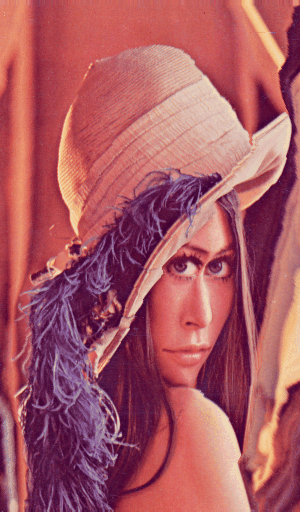

In [54]:
show_pnm("300_host.pnm")